In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
from numpy import percentile
from sklearn.metrics import mean_squared_error
from math import sqrt
import statistics
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
pd.options.mode.chained_assignment = None  # default='warn'

Importing plotly failed. Interactive plots will not work.


In [3]:
df1 = pd.read_csv('pd (1).csv')
df1.head()

,DailyUsagesId,AccountNumber,Usagedate,Value,Consumed,MeterId,RatePlanDetailId
0,723494,6,2018-09-15 00:00:00.000,5.162,5.162,4,1
1,722606,6,2018-09-16 00:00:00.000,5.138,5.138,4,1
2,722532,6,2018-09-17 00:00:00.000,5.507,5.507,4,1
3,723495,6,2018-09-18 00:00:00.000,17.481,17.481,4,1
4,722607,6,2018-09-19 00:00:00.000,7.083,7.083,4,1


In [4]:
df1 = df1.rename(columns={'Value': 'Component_A'})

In [5]:
df1['Component_B'] = df1['Component_A'] + 1
df1['Component_C'] = df1['Component_A'] + 2
df1.loc[df1.AccountNumber == 429, 'RatePlanDetailId'] = 2
df1

,DailyUsagesId,AccountNumber,Usagedate,Component_A,Consumed,MeterId,RatePlanDetailId,Component_B,Component_C
0,723494,6,2018-09-15 00:00:00.000,5.162,5.162,4,1,6.162,7.162
1,722606,6,2018-09-16 00:00:00.000,5.138,5.138,4,1,6.138,7.138
2,722532,6,2018-09-17 00:00:00.000,5.507,5.507,4,1,6.507,7.507
3,723495,6,2018-09-18 00:00:00.000,17.481,17.481,4,1,18.481,19.481
4,722607,6,2018-09-19 00:00:00.000,7.083,7.083,4,1,8.083,9.083
...,...,...,...,...,...,...,...,...,...
240913,1470076,594,2019-08-08 00:00:00.000,100.556,100.556,790,1,101.556,102.556
240914,1476018,594,2019-08-09 00:00:00.000,62.268,62.268,790,1,63.268,64.268
240915,1481976,594,2019-08-10 00:00:00.000,46.227,46.227,790,1,47.227,48.227
240916,1487920,594,2019-08-11 00:00:00.000,71.044,71.044,790,1,72.044,73.044


In [6]:
df1['Usagedate'] = pd.to_datetime(df1['Usagedate'])

In [7]:
#Unique Account Numbers
df1.AccountNumber.nunique()

383

In [8]:
#Unique Meter IDs
df1.MeterId.nunique()

387

In [9]:
df1 = df1.drop(['DailyUsagesId','Consumed'],axis=1)
df1

,AccountNumber,Usagedate,Component_A,MeterId,RatePlanDetailId,Component_B,Component_C
0,6,2018-09-15,5.162,4,1,6.162,7.162
1,6,2018-09-16,5.138,4,1,6.138,7.138
2,6,2018-09-17,5.507,4,1,6.507,7.507
3,6,2018-09-18,17.481,4,1,18.481,19.481
4,6,2018-09-19,7.083,4,1,8.083,9.083
...,...,...,...,...,...,...,...
240913,594,2019-08-08,100.556,790,1,101.556,102.556
240914,594,2019-08-09,62.268,790,1,63.268,64.268
240915,594,2019-08-10,46.227,790,1,47.227,48.227
240916,594,2019-08-11,71.044,790,1,72.044,73.044


In [10]:
#Visualization of Data for a given Account Number
def visuals(account):
    x = pd.DataFrame()
    x = df1[df1.AccountNumber == account]
    meterIDs = df1[df1.AccountNumber == account].MeterId.unique()
    for i in meterIDs:
        meterIDs_df = x[x.MeterId == i]
        meterIDs_df = meterIDs_df.drop(['AccountNumber','MeterId'],axis=1)
        print("-----------------")
        print("Meter ID "+str(i)+" dataframe:\n"+str(meterIDs_df))
        print("-----------------")
        plt.figure(figsize=(15,6))
        sns.lineplot(x = "Usagedate", y = "Component_A", data = meterIDs_df.sort_values('Usagedate'))
        plt.xlabel('Date')
        plt.ylabel('Component_A')
        plt.title('Component A Usage Plot for Account Number: '+ str(account)+ ' Meter ID: '+ str(i))
    return x.head(45)

-----------------
Meter ID 654 dataframe:
        Usagedate  Component_A  RatePlanDetailId  Component_B  Component_C
196366 2018-07-25       56.380                 1       57.380       58.380
196367 2018-07-26       64.459                 1       65.459       66.459
196368 2018-07-27       72.312                 1       73.312       74.312
196369 2018-07-28       83.039                 1       84.039       85.039
196370 2018-07-29       75.003                 1       76.003       77.003
...           ...          ...               ...          ...          ...
197001 2020-08-30       80.301                 1       81.301       82.301
197002 2020-08-31       75.797                 1       76.797       77.797
197003 2020-09-01       72.276                 1       73.276       74.276
197004 2020-09-02       63.616                 1       64.616       65.616
197005 2020-09-03        3.280                 1        4.280        5.280

[640 rows x 5 columns]
-----------------


,AccountNumber,Usagedate,Component_A,MeterId,RatePlanDetailId,Component_B,Component_C
196366,493,2018-07-25,56.380,654,1,57.380,58.380
196367,493,2018-07-26,64.459,654,1,65.459,66.459
196368,493,2018-07-27,72.312,654,1,73.312,74.312
196369,493,2018-07-28,83.039,654,1,84.039,85.039
196370,493,2018-07-29,75.003,654,1,76.003,77.003
196371,493,2018-07-30,75.242,654,1,76.242,77.242
196372,493,2018-07-31,54.017,654,1,55.017,56.017
196373,493,2018-08-01,59.703,654,1,60.703,61.703
196374,493,2018-08-02,65.763,654,1,66.763,67.763
196375,493,2018-08-03,68.350,654,1,69.350,70.350


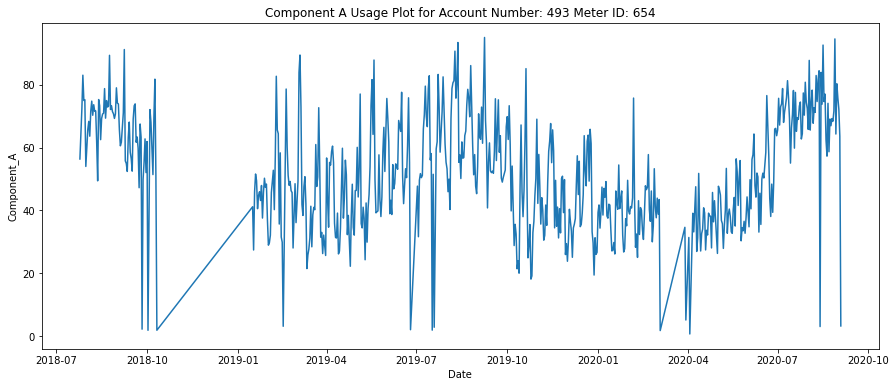

In [11]:
visuals(493)

-----------------
Meter ID 580 dataframe:
        Usagedate  Component_A  RatePlanDetailId  Component_B  Component_C
172591 2018-07-25        0.922                 2        1.922        2.922
172592 2018-07-26        1.021                 2        2.021        3.021
172593 2018-07-27        1.044                 2        2.044        3.044
172594 2018-07-28        1.076                 2        2.076        3.076
172595 2018-07-29        1.067                 2        2.067        3.067
...           ...          ...               ...          ...          ...
173226 2020-08-30        4.066                 2        5.066        6.066
173227 2020-08-31        4.278                 2        5.278        6.278
173228 2020-09-01        3.168                 2        4.168        5.168
173229 2020-09-02        3.402                 2        4.402        5.402
173230 2020-09-03        0.094                 2        1.094        2.094

[640 rows x 5 columns]
-----------------


,AccountNumber,Usagedate,Component_A,MeterId,RatePlanDetailId,Component_B,Component_C
172591,429,2018-07-25,0.922,580,2,1.922,2.922
172592,429,2018-07-26,1.021,580,2,2.021,3.021
172593,429,2018-07-27,1.044,580,2,2.044,3.044
172594,429,2018-07-28,1.076,580,2,2.076,3.076
172595,429,2018-07-29,1.067,580,2,2.067,3.067
172596,429,2018-07-30,1.051,580,2,2.051,3.051
172597,429,2018-07-31,1.021,580,2,2.021,3.021
172598,429,2018-08-01,1.046,580,2,2.046,3.046
172599,429,2018-08-02,1.022,580,2,2.022,3.022
172600,429,2018-08-03,1.091,580,2,2.091,3.091


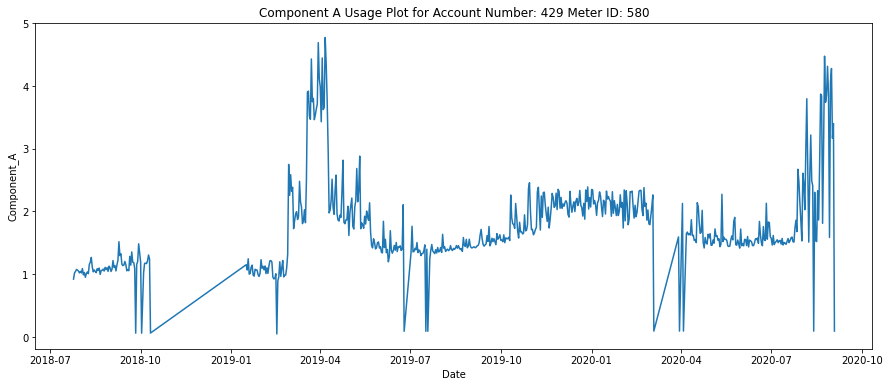

In [12]:
visuals(429)

In [ ]:
def outlier():
    

In [75]:
def mape_new(yTrue,yPredicted):
    return np.abs((yTrue - yPredicted) / yTrue) * 100

In [76]:
def compA(i, df2, testdays, billing_cycle):
    
    meterID_df = df2[df2.MeterId == i]
    meterID_df = meterID_df.drop(['AccountNumber','MeterId','RatePlanDetailId','Component_B','Component_C'],axis=1)
    final = meterID_df.reset_index()[['Usagedate','Component_A']].rename({'Usagedate':'ds','Component_A':'y'}, axis='columns')
    train = final[:len(final)-testdays] # training data
    original = final[len(final)-billing_cycle:] # constant data, depends on the billing cycle period and not on the varying input argument of testdays
    test = final[len(final)-testdays:] # test data, depends on the input argument
    test_remaining = original[:len(original)-testdays] # remaining data, difference of the 
    sum_test_remaining = test_remaining['y'].sum()
    sum_actual = original['y'].sum()
    test_df_median = final[len(final)-90:]
    p = Prophet(daily_seasonality = False, weekly_seasonality = False, yearly_seasonality = True)
    p.fit(train)
    prediction = p.make_future_dataframe(periods=testdays , freq='D')
    fore = p.predict(prediction)
    test['Predictions'] = fore['yhat']
    combined = pd.DataFrame()
    combined['ds'] = original['ds']
    combined['y'] = test_remaining['y'].append(test['Predictions'])
    sum_predictions = test['Predictions'].sum()
    sum_predictions_final = sum_predictions + sum_test_remaining
    
    MAPE_new = mape_new(sum_actual, sum_predictions_final)
    
    return sum_predictions_final

In [77]:
def compB(i, df2, testdays, billing_cycle):
    
    meterID_df = df2[df2.MeterId == i]
    meterID_df = meterID_df.drop(['AccountNumber','MeterId','RatePlanDetailId','Component_A','Component_C'],axis=1)
    final = meterID_df.reset_index()[['Usagedate','Component_B']].rename({'Usagedate':'ds','Component_B':'y'}, axis='columns')
    train = final[:len(final)-testdays] # training data
    original = final[len(final)-billing_cycle:] # constant data, depends on the billing cycle period and not on the varying input argument of testdays
    test = final[len(final)-testdays:] # test data, depends on the input argument
    test_remaining = original[:len(original)-testdays] # remaining data, difference of the 
    sum_test_remaining = test_remaining['y'].sum()
    sum_actual = original['y'].sum()
    test_df_median = final[len(final)-90:]
    p = Prophet(daily_seasonality = False, weekly_seasonality = False, yearly_seasonality = True)
    p.fit(train)
    prediction = p.make_future_dataframe(periods=testdays , freq='D')
    fore = p.predict(prediction)
    test['Predictions'] = fore['yhat']
    combined = pd.DataFrame()
    combined['ds'] = original['ds']
    combined['y'] = test_remaining['y'].append(test['Predictions'])
    sum_predictions = test['Predictions'].sum()
    sum_predictions_final = sum_predictions + sum_test_remaining
    
    MAPE_new = mape_new(sum_actual, sum_predictions_final)
    
    return sum_predictions_final

In [78]:
def compC(i, df2, testdays, billing_cycle):
    
    meterID_df = df2[df2.MeterId == i]
    meterID_df = meterID_df.drop(['AccountNumber','MeterId','Component_A','Component_B','RatePlanDetailId'],axis=1)
    final = meterID_df.reset_index()[['Usagedate','Component_C']].rename({'Usagedate':'ds','Component_C':'y'}, axis='columns')
    train = final[:len(final)-testdays] # training data
    original = final[len(final)-billing_cycle:] # constant data, depends on the billing cycle period and not on the varying input argument of testdays
    test = final[len(final)-testdays:] # test data, depends on the input argument
    test_remaining = original[:len(original)-testdays] # remaining data, difference of the 
    sum_test_remaining = test_remaining['y'].sum()
    sum_actual = original['y'].sum()
    test_df_median = final[len(final)-90:]
    p = Prophet(daily_seasonality = False, weekly_seasonality = False, yearly_seasonality = True)
    p.fit(train)
    prediction = p.make_future_dataframe(periods=testdays , freq='D')
    fore = p.predict(prediction)
    test['Predictions'] = fore['yhat']
    combined = pd.DataFrame()
    combined['ds'] = original['ds']
    combined['y'] = test_remaining['y'].append(test['Predictions'])
    sum_predictions = test['Predictions'].sum()
    sum_predictions_final = sum_predictions + sum_test_remaining
    
    MAPE_new = mape_new(sum_actual, sum_predictions_final)
    
    return sum_predictions_final

In [95]:
#Main function for prediction.
#Inputs are: Account Number; Number of days you want to predict for; Billing Cycle period.
#Outputs are: Sum of 90 days usage (actual); Sum of predicted usage and actual remaining days usage; Maximum of Predicted Usage (including the max from the remaining actual datapoints added); Minimum of Predicted Usage (including the min from the remaining actual datapoints added); Median of Predicted Usage (including the median from the remaining actual datapoints added)
def account_and_days(ano, testdays, billing_cycle):
    total_compA_usage = 0   # the sum of predicted usages (if more than one meter) 
    total_compA_bill = 0
    total_compB_usage = 0   # the sum of predicted usages (if more than one meter) 
    total_compB_bill = 0
    total_compC_usage = 0
    compCbill=0              # the sum of predicted usages (if more than one meter)
    total_compC_bill = 0
    tier1_rate=10
    tier2_rate=20
    threshold=70
    rate = 15
    supply_charge = 50
    
    df2 = pd.DataFrame()
    df2 = df1[df1.AccountNumber == ano]
    meterID_list = df1[df1.AccountNumber == ano].MeterId.unique()
    for i in meterID_list:
        
        compAusage = compA(i, df2, testdays, billing_cycle)
        print('Component A usage for Meter ID ',i,': %.3f' % compAusage)
        total_compA_usage = total_compA_usage + compAusage
        
        compAbill = (compAusage * rate) + supply_charge
        print('Component A bill for Meter ID ',i,': $ %.3f' % compAbill)
        total_compA_bill = total_compA_bill + compAbill
        
        print()
        
        compBusage = compB(i, df2, testdays, billing_cycle)
        print('Component B usage for Meter ID ',i,': %.3f' % compBusage)
        total_compB_usage = total_compB_usage + compBusage
        
        compBbill = (compBusage * rate) + supply_charge
        print('Component B bill for Meter ID ',i,': $ %.3f' % compBbill)
        total_compB_bill = total_compB_bill + compBbill
        
        print()
        x = df1[df1.MeterId == i].RatePlanDetailId
        res = x.to_frame().rename({'RatePlanDetailId':'RatePlan'}, axis='columns')
        if ((res['RatePlan']==1).all()) :
                compCusage = compC(i, df2, testdays, billing_cycle)
                print('Component C usage for Meter ID ',i,': %.3f' % compCusage)
                total_compC_usage = total_compC_usage + compCusage

                compCbill = (compCusage * rate) + supply_charge
                print('Component C bill for Meter ID ',i,': $ %.3f' % compCbill)
                total_compC_bill = total_compC_bill + compCbill
        elif ((res['RatePlan']==2).all()) :
                compCusage = compC(i, df2, testdays, billing_cycle)
                print('Component C usage for Meter ID ',i,': %.3f' % compCusage)
                total_compC_usage = total_compC_usage + compCusage
                
                if (total_compC_usage <=  threshold):
                    compCbill = compCbill + (compCusage * tier1_rate ) + supply_charge
                elif (total_compC_usage >  threshold):
                    compCbill = compCbill + (compCusage * tier2_rate ) + supply_charge
                
                print('Component C bill for Meter ID ',i,': $ %.3f' % compCbill)
                total_compC_bill = total_compC_bill + compCbill   
        print()
        
    print('Total Component A usage for Account Number ',ano,': %.3f' % total_compA_usage)
    print('Total Component A bill for Account Number ',ano,': $ %.3f' % total_compA_bill)
    print()
    print('Total Component B usage for Account Number ',ano,': %.3f' % total_compB_usage)
    print('Total Component B bill for Account Number ',ano,': $ %.3f' % total_compB_bill)
    print()
    print('Total Component C usage for Account Number ',ano,': %.3f' % total_compC_usage)
    print('Total Component C bill for Account Number ',ano,': $ %.3f' % total_compC_bill)
    

In [96]:
account_and_days(429, 90, 90)

Component A usage for Meter ID  580 : 69.715
Component A bill for Meter ID  580 : $ 1095.720

Component B usage for Meter ID  580 : 152.234
Component B bill for Meter ID  580 : $ 2333.503

Component C usage for Meter ID  580 : 230.836
Component C bill for Meter ID  580 : $ 4666.718

Total Component A usage for Account Number  429 : 69.715
Total Component A bill for Account Number  429 : $ 1095.720

Total Component B usage for Account Number  429 : 152.234
Total Component B bill for Account Number  429 : $ 2333.503

Total Component C usage for Account Number  429 : 230.836
Total Component C bill for Account Number  429 : $ 4666.718
